<a href="https://colab.research.google.com/github/sverdoot/DL-in-NLP-course/blob/master/workshop%203/task1_char_language_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Посимвольная языковая модель.

В первом задании Вам нужно написать и обучить посимвольную нейронную языковую модель для вычисления вероятностей буквенных последовательностей (то есть слов). Такие модели используются в задачах словоизменения и распознавания/порождения звучащей речи. Для обучения модели используйте данные для русского языка из [репозитория](https://github.com/sigmorphon/conll2018/tree/master/task1/surprise).

**В процессе написания Вам нужно решить следующие проблемы:**
    
* как будет выглядеть обучающая выборка; что будет являться признаками, и что - метками классов.
* как сделать так, чтобы модель при предсказании символа учитывала все предыдущие символы слова.
* какие специальные символы нужно использовать.
* как передавать в модель текущее состояние рекуррентной сети

**Результаты:**

* предобработчик данных,
* генератор обучающих данных (батчей),
* обученная модель
* перплексия модели на настроечной выборке
* посимвольные вероятности слов в контрольной выборке

**Дополнительно:**

* дополнительный вход модели (часть речи слова, другие морфологические признаки), влияет ли его добавление на перплексию
* сравнение различных архитектур нейронной сети (FC, RNN, LSTM, QRNN, ...)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# it is better to do all imports at the first cell
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from IPython.core.debugger import set_trace
from torch import optim

USE_CUDA = torch.cuda.is_available()
device=torch.device('cuda:0') # or set to 'cpu'
print("CUDA:", USE_CUDA)
print(device)

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

import re
from matplotlib import pyplot as plt

CUDA: True
cuda:0


In [0]:
def read_dataset(infile):
    words, tags = [], []
    with open(infile, "r", encoding="utf8") as f:
        for line in f:
            line = line.strip()
            splitted = line.split("\t")
            if len(splitted) != 3:
                continue
            words.append(splitted[0].lower())
            tags.append(splitted[2])
    return words, tags

train_words, train_tags = read_dataset("/content/drive/My Drive/Colab Notebooks/DL in NLP/Work3/russian-train-high")
dev_words, dev_tags = read_dataset("/content/drive/My Drive/Colab Notebooks/DL in NLP/Work3/russian-dev")
test_words, test_tags = read_dataset("/content/drive/My Drive/Colab Notebooks/DL in NLP/Work3/russian-covered-test")

In [0]:
def make_data(words):
    data = [re.findall(r'^(\w+)', re.sub(r'<.*>', "", x))[0] for x in train_words]
    data = list(filter(lambda x: re.match(r'^[а-я]', x), data))
    return data
train_data = make_data(train_words)
eval_data = make_data(dev_words)
test_data = make_data(test_words)

In [0]:
max_len = np.max([len(x) for x in train_data])
max_len

23

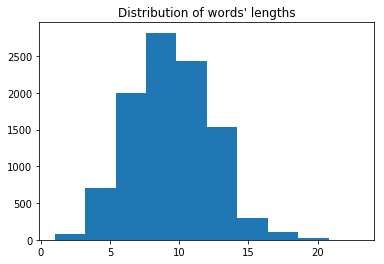

In [0]:
lens = [len(x) for x in train_data]
plt.hist(lens)
plt.title('Distribution of words\' lengths')
plt.show()

In [0]:
MAX_LEN = max(lens)

Подумайте, какие вспомогательные токены могут быть вам полезны. Выдайте им индексы от `0` до `len(AUXILIARY) - 1`

## Vocabulary

In [0]:
#START_TOKEN = '<START>'
EOS_TOKEN = '<EOS>'
UNK_TOKEN = '<UNK>'
PAD_TOKEN = '<PAD>'
AUXILIARY = [PAD_TOKEN, EOS_TOKEN]

In [0]:
class Vocabulary:
    def fit(self, data):
        """Extract unique symbols from the data, make itos (item to string) and stoi (string to index) objects"""
        symbols = set(x for elem in data for x in elem)
        self._symbols = AUXILIARY + sorted(symbols)
        
        # Запомните следующую строчку кода - она нужна примерно всегда
        self._symbol_codes = {s: i for i, s in enumerate(self._symbols)}
        self._codes_symbol = {i: s for i, s in enumerate(self._symbols)}
        print(self._symbols)
        print(self._symbol_codes)
        return self

    def __len__(self):
        return len(self._symbols)

    def transform(self, data):
        """Transform data to indices
        Input:
            - data, list of strings
        Output:
            - list of list of char indices

        >>> self.transform(['word1', 'token2'])
        >>> [[24, 2, 19, 13, 3], [8, 2, 9, 1, 7, 4]]
        """
        
        data_ind = [[self._symbol_codes[x] for x in word] for word in data]
        return data_ind
    
    def tok2idx(self, tok):
        return self._symbol_codes[tok]
    
    def idx2tok(self, idx):
        return self._codes_symbol[idx]

In [0]:
voc = Vocabulary()
voc.fit(train_data)
voc.__len__()


['<PAD>', '<EOS>', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё']
{'<PAD>': 0, '<EOS>': 1, 'а': 2, 'б': 3, 'в': 4, 'г': 5, 'д': 6, 'е': 7, 'ж': 8, 'з': 9, 'и': 10, 'й': 11, 'к': 12, 'л': 13, 'м': 14, 'н': 15, 'о': 16, 'п': 17, 'р': 18, 'с': 19, 'т': 20, 'у': 21, 'ф': 22, 'х': 23, 'ц': 24, 'ч': 25, 'ш': 26, 'щ': 27, 'ъ': 28, 'ы': 29, 'ь': 30, 'э': 31, 'ю': 32, 'я': 33, 'ё': 34}


35

In [0]:
PAD_IDX = voc.tok2idx(PAD_TOKEN)
EOS_IDX = voc.tok2idx(EOS_TOKEN)
#SOS_IDX = voc.tok2idx(START_TOKEN)

## Batcher

In [0]:
class Batcher:
  
  def __init__(self, batch_size, data, data_idx=0):
    self.batch_size = batch_size
    self.data = data
    self.data_idx = data_idx
    
  def __iter__(self):
  
    return self

  def __next__(self, data_idx_=None):
    batch_size = self.batch_size
    data = self.data
    global data_idx
    batch = []
    target = []
    lengths =[]
    whole = []

    n_timestep = np.max([len(data[idx % len(data)]) for idx in range(self.data_idx, self.data_idx + batch_size)])
    
    for i in range(batch_size):
      word = data[self.data_idx]
      x = voc.transform([word])[0]
      y = x[1:] + [EOS_IDX] + [PAD_IDX] * (n_timestep - len(word))
      #y = x[1:] + [PAD_IDX] * (n_timestep - len(word) + 1)
      x.append(EOS_IDX)
      x = x + [PAD_IDX] * (n_timestep - len(word))
      
      whole.append((x,
                    y,
                    len(word)))
      self.data_idx = (self.data_idx + 1) % len(data)
      
    whole = sorted(whole, key=lambda x: x[2], reverse=True)
    batch = [x[0] for x in whole]
    target = [x[1] for x in whole]
    lengths = [x[2] for x in whole]
    return (batch, target, lengths)

In [0]:
ex_batcher = Batcher(10, train_data, np.random.randint(len(train_data)))
build_batch = iter(ex_batcher)
next(build_batch)

([[14, 2, 13, 16, 25, 10, 19, 13, 7, 15, 15, 29, 11, 1],
  [10, 14, 17, 16, 15, 10, 18, 16, 4, 2, 20, 30, 1, 0],
  [13, 2, 19, 12, 2, 20, 7, 13, 30, 15, 16, 7, 1, 0],
  [4, 2, 18, 30, 10, 18, 16, 4, 2, 20, 30, 1, 0, 0],
  [17, 16, 13, 15, 16, 5, 13, 2, 19, 10, 7, 1, 0, 0],
  [17, 18, 16, 19, 13, 2, 4, 10, 20, 30, 1, 0, 0, 0],
  [12, 18, 29, 14, 25, 2, 15, 10, 15, 1, 0, 0, 0, 0],
  [17, 16, 20, 18, 33, 19, 15, 29, 11, 1, 0, 0, 0, 0],
  [13, 32, 3, 16, 4, 15, 29, 11, 1, 0, 0, 0, 0, 0],
  [24, 4, 7, 20, 16, 25, 7, 12, 1, 0, 0, 0, 0, 0]],
 [[2, 13, 16, 25, 10, 19, 13, 7, 15, 15, 29, 11, 1],
  [14, 17, 16, 15, 10, 18, 16, 4, 2, 20, 30, 1, 0],
  [2, 19, 12, 2, 20, 7, 13, 30, 15, 16, 7, 1, 0],
  [2, 18, 30, 10, 18, 16, 4, 2, 20, 30, 1, 0, 0],
  [16, 13, 15, 16, 5, 13, 2, 19, 10, 7, 1, 0, 0],
  [18, 16, 19, 13, 2, 4, 10, 20, 30, 1, 0, 0, 0],
  [18, 29, 14, 25, 2, 15, 10, 15, 1, 0, 0, 0, 0],
  [16, 20, 18, 33, 19, 15, 29, 11, 1, 0, 0, 0, 0],
  [32, 3, 16, 4, 15, 29, 11, 1, 0, 0, 0, 0, 0],
  [4,

## Model

In [0]:
class Model(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, num_layers=1, dropout=0.):
        super(Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.letter_in_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=PAD_IDX)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, bidirectional=False, dropout=dropout)

        # The linear layer that maps from hidden state space to tag space
        self.letter_out_embeddings = nn.Linear(hidden_dim, vocab_size)

    def forward(self, word, lens):
        embeds = self.letter_in_embeddings(word)
        packed = pack_padded_sequence(embeds, lens, batch_first=True)
        output, final = self.lstm(packed)
        output, _ = pad_packed_sequence(output, batch_first=True)
        outs = self.letter_out_embeddings(output)
        tag_scores = F.log_softmax(outs, dim=-1)
        return tag_scores
    
    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_dim, device = device), torch.zeros(self.num_layers, batch_size, self.hidden_dim, device = device)

## Training

In [0]:
def data_gen(data, batch_size, num_batches, data_idx=0):
    batcher = Batcher(batch_size, data, data_idx)
    build_batch = iter(batcher)
    for i in range(num_batches):
        yield next(build_batch)

In [0]:
def train(model, num_epochs=10, lr=0.003, print_every=100):
    
    if USE_CUDA:
        model.cuda()
    train_data_idx = 0
    eval_data_idx = 0

    criterion = nn.NLLLoss(reduction="sum", ignore_index=PAD_IDX)
    if USE_CUDA:
        criterion = criterion.cuda()
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    
    dev_perplexities = []
    train_perplexities = []
    losses = []

    for epoch in range(num_epochs):
        train_data_iter = data_gen(data=train_data, batch_size=batch_size, num_batches=train_num_batches, data_idx=train_data_idx)
        train_data_idx = (train_data_idx + (batch_size * train_num_batches)) % len(train_data)
        
        #hidden = model.init_hidden(batch_size)
        model.train()
        train_perplexity, loss = run_epoch(train_data_iter, 
                                     model,
                                     optim,
                                     criterion,
                                     print_every=print_every)
        train_perplexities.append(train_perplexity)
        losses.append(loss)
        model.eval()
        eval_data_iter = data_gen(data=eval_data, batch_size=eval_batch_size, num_batches=eval_num_batches, data_idx=eval_data_idx)
        eval_data_idx = (eval_data_idx + (eval_batch_size * eval_num_batches)) % len(eval_data)
        with torch.no_grad():
           #print_examples((rebatch(PAD_IDX, x) for x in valid_iter), 
           #               model, n=3, src_vocab=SRC.vocab, trg_vocab=TRG.vocab)        
            dev_perplexity, loss = run_epoch(eval_data_iter, 
                                       model,
                                       optim,
                                       criterion
                                       )
            print("Epoch: {}, Validation perplexity: {}".format(epoch, dev_perplexity))
            dev_perplexities.append(dev_perplexity)
            
        if epoch % print_every == 0:
            print("Epoch: {}, Loss: {}, Perplexity: {} ".format(epoch, loss, train_perplexity))
        
    return dev_perplexities, train_perplexities, losses

In [0]:
def run_epoch(data_iter, model, optimizer, loss_function, print_every=50):
    """Standard Training and Logging Function"""

    start = time.time()
    total_tokens = 0
    total_loss = 0
    #print_tokens = 0

    for i, batch in enumerate(data_iter, 1):
        src, trg, lens = batch
        src = torch.tensor(src, dtype=torch.long).to(device=device)
        trg = torch.tensor(trg, dtype=torch.long).to(device=device)
        batch_size_ = src.size(0)
        scores = model.forward(src, lens).to(device=device)
        loss = loss_function(scores.view(batch_size_ * max(lens), -1).to(dtype=torch.float32), trg.view(batch_size_ * max(lens)))
        
        total_loss = total_loss + loss
        #loss = loss / batch_size
        
        if model.training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_tokens = total_tokens + sum(lens)

    return math.exp(total_loss / float(total_tokens)), total_loss / float(total_tokens)

In [0]:
batch_size = 100
eval_batch_size = 16
vocab_size = voc.__len__()

train_num_batches = len(train_data) // batch_size
eval_num_batches = len(eval_data) // eval_batch_size

In [0]:
model = Model(embedding_dim=voc.__len__(), hidden_dim=512, vocab_size=voc.__len__(), num_layers=4, dropout=0.1).to(device=device)

In [0]:
dev_perplexities, train_perplexities, loss = train(model, print_every=10, num_epochs=50, lr=0.003)

Epoch: 0, Validation perplexity: 7.502366441610634
Epoch: 0, Loss: 2.015218496322632, Perplexity: 11.961264604322748 
Epoch: 1, Validation perplexity: 5.839824648094398
Epoch: 2, Validation perplexity: 4.90759182240103
Epoch: 3, Validation perplexity: 4.289663231595303
Epoch: 4, Validation perplexity: 3.782994385503826
Epoch: 5, Validation perplexity: 3.403978279927086
Epoch: 6, Validation perplexity: 3.0780618279279017
Epoch: 7, Validation perplexity: 2.8527184201166516
Epoch: 8, Validation perplexity: 2.636631016767155
Epoch: 9, Validation perplexity: 2.51929110357708
Epoch: 10, Validation perplexity: 2.4448328289938117
Epoch: 10, Loss: 0.8939767479896545, Perplexity: 2.6252899951597835 
Epoch: 11, Validation perplexity: 2.382263418888382
Epoch: 12, Validation perplexity: 2.3349786130839205
Epoch: 13, Validation perplexity: 2.3050068850798136
Epoch: 14, Validation perplexity: 2.2709193902936
Epoch: 15, Validation perplexity: 2.243022025659229
Epoch: 16, Validation perplexity: 2.23433

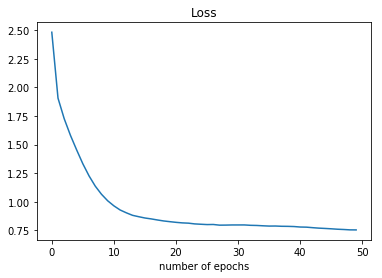

In [0]:
plt.plot(loss)
plt.title("Loss")
plt.xlabel("number of epochs")
plt.show()

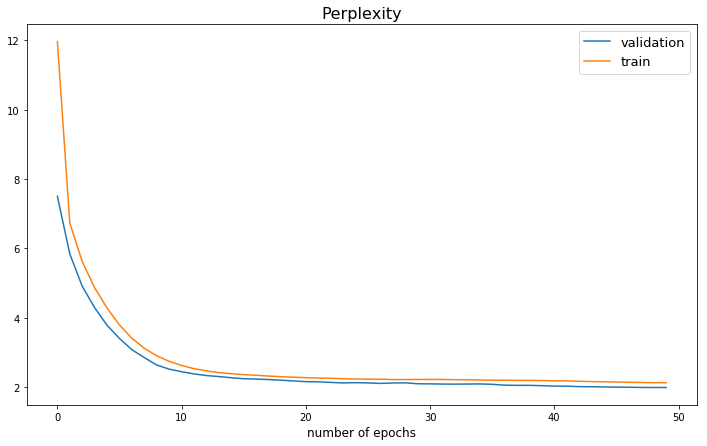

In [0]:
plt.figure(figsize=(12,7))
plt.plot(dev_perplexities, label="validation")
plt.plot(train_perplexities, label="train")
plt.legend(fontsize=13)
plt.title("Perplexity", fontsize=16)
plt.xlabel("number of epochs", fontsize=12)
plt.show()

In [0]:
torch.save(model.state_dict(), "/content/drive/My Drive/Colab Notebooks/DL in NLP/Work3/LSTM")

## Predictions and probabilities per-symbol on test sample

In [0]:
import pandas as pd

In [0]:
def compute_probs(data, model, num_exams=20, data_idx=0):
    data_iter = data_gen(data=data, batch_size=1, num_batches=num_exams, data_idx=data_idx)
    probs = []
    hidden = model.init_hidden(batch_size=1)
    for i, batch in enumerate(data_iter, 1):
      src, trg, lens = batch
      src = torch.tensor(src, dtype=torch.long).to(device=device)
      trg = torch.tensor(trg, dtype=torch.long).to(device=device)
      batch_size = src.size(0)
      model.eval()
      scores = model.forward(src, lens).to(device=device)
      scores = scores[0].to(device='cpu').detach().numpy()
      trg = trg.to(device='cpu')
      sc = np.exp(scores)
      trg_word = [voc.idx2tok(x) for x in trg[0].detach().numpy()]
      pred_word = [voc.idx2tok(x) for x in np.argmax(scores, axis=1)]
      #print(''.join(pred_word), '\t||\t',\
      #      ''.join(trg_word))
      x = []
      for j in range(len(scores)):
          x.append(math.exp(scores[j, trg[0, j]]))
      probs.append((np.prod(x), lens[0], 1/voc.__len__()**(lens[0])))
      x = np.round(x, 2)
      #print({trg_word[i]: x[i] for i, _ in enumerate(x)})
      df = pd.DataFrame({i: [pred_word[i], trg_word[i], x[i]] for i, _ in enumerate(x)})
      print("Example %d" % i) 
      print(df)
      print("\nProbability of the whole word: {}\nlength of the word: {}\nprobability from the random model: {}".format(probs[-1][0], probs[-1][1], probs[-1][2]))
      print("###################################################################")
      
data_idx = np.random.randint(len(test_data)-21)
compute_probs(test_data, model, num_exams=30, data_idx=data_idx)

Example 1
      0     1     2     3     4     5  6  7      8
0     р     и     п     т     н     у  т  ь  <EOS>
1     р     у     с     т     н     у  т  ь  <EOS>
2  0.22  0.15  0.26  0.99  0.97  0.98  1  1      1

Probability of the whole word: 0.008012112472980209
length of the word: 9
probability from the random model: 1.2687837297914905e-14
###################################################################
Example 2
      0     1     2  3  4     5     6     7     8      9
0     е     к     р  о  в     ы     ш     н     я  <EOS>
1     а     в     р  о  в     и     ш     н     я  <EOS>
2  0.17  0.09  0.72  1  1  0.07  0.99  0.97  0.99      1

Probability of the whole word: 0.0007541182036997976
length of the word: 10
probability from the random model: 3.62509637083283e-16
###################################################################
Example 3
    0     1    2     3  4     5  6  7  8  9      10
0    б     о    е     с  н     я  т  ь  с  я  <EOS>
1    б     ъ    я     с  н     я